Made on 3/2. To make a version of ARC V2E with more room on the midplane, to see how much the plasma can shift with a divertor coil

# TokaMaker mesh builder example for ARC

In [118]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

ind = 23
pts = np.array([[3.4, 2.1], [3.35, 2.16],[3.3, 2.22],[3.25, 2.28], [3.2, 2.34], [4.4, 2.37], [4.5, 2.49], [4.6, 2.61],[4.7, 2.73], [4.8, 2.85], [4.9, 2.97], [5, 3.09], [3.64, 2.15],[3.59, 2.21],[3.54, 2.27],[3.49, 2.33], [4.21, 2.49], [4.31, 2.615], [4.41, 2.74], [4.51, 2.865],[4.61, 2.99], [4.71, 3.115],[4.81, 3.24]    ])
pt = pts[ind,:]

IndexError: index 23 is out of bounds for axis 0 with size 23

## Load TokaMaker library
To load the TokaMaker python module we need to tell python where to the module is located. This can be done either through the PYTHONPATH environment variable or using within a script using sys.path.append() as below, where we look for the environement variable OFT_ROOTPATH to provide the path to where the OpenFUSIONToolkit is installed (/Applications/OFT on macOS).

For meshing we will use the gs_Domain class to build a 2D triangular grid suitable for Grad-Shafranov equilibria. This class uses the triangle code through a python wrapper.

In [106]:
sys.path.append('/Applications/OpenFUSIONToolkit/python')
tokamaker_python_path = os.getenv('OFT_ROOTPATH')
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))
from OpenFUSIONToolkit.TokaMaker.meshing import gs_Domain, save_gs_mesh

include_blanket = True 
include_FLIBE = False
vvresoption = False

jsonname = 'device_V2E'

## Load geometry information
The geometry information (eg. bounding curves for vacuum vessels) are now loaded from a JSON file. This JSON file contains the following:

- limiter: A contour of R,Z points defining the limiter (PFC) surface
- inner_vv: Two contours of R,Z points defining the inner and outer boundary of the inner vacuum vessel
- outer_vv: Two contours of R,Z points defining the inner and outer boundary of the outer vacuum vessel
- coils: A dictionary of R,Z,W,H values defining the PF coils as rectangles in the poloidal cross-section

This JSON is built from the device description, but in the future we will have a workflow to generate the mesh directly from the device description. For simple geometries, testing, or generative usage this can be created directly in the code.

In [107]:
## LOAD IDS
f = open(f'{jsonname}.json')
mach = json.load(f)

## Define coil array

This takes some work to extract from the filament representation in the device.json file....

NOTE: I haven't figured a good way to robustly get the coil width and height out yet. Here we just multiply by 6* the filament radius, which gets to within 1cm for each coil, which will have to be good enough for now.

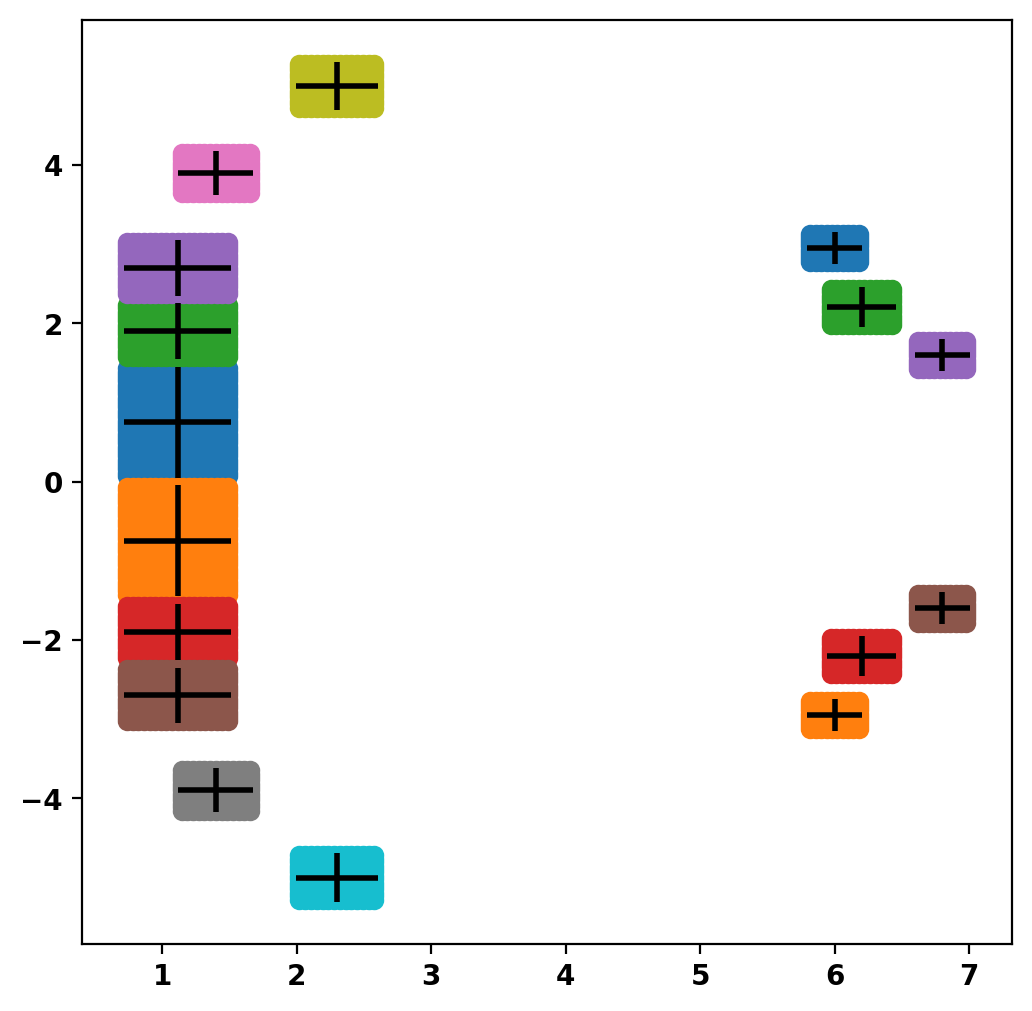

cs1u 1.12 0.75 0.79 1.4
cs1l 1.12 -0.75 0.79 1.4
cs2u 1.12 1.9 0.79 0.7
cs2l 1.12 -1.9 0.79 0.7
cs3u 1.12 2.7 0.79 0.7
cs3l 1.12 -2.7 0.79 0.7
pf1u 1.4 3.9 0.56 0.56
pf1l 1.4 -3.9 0.56 0.56
pf2u 2.3 5.0 0.61 0.61
pf2l 2.3 -5.0 0.61 0.61
pf3u 6.0 2.95 0.41 0.41
pf3l 6.0 -2.95 0.41 0.41
pf4u 6.2 2.2 0.51 0.51
pf4l 6.2 -2.2 0.51 0.51
pf5u 6.8 1.6 0.41 0.41
pf5l 6.8 -1.6 0.41 0.41


In [108]:
coil_data = {}

plt.figure()
for coil in mach['pf_active']['coil']:
    coil_data[coil['name']] = {}
    coil_data[coil['name']]['rs'] = np.zeros(len(coil['element']))
    coil_data[coil['name']]['zs'] = np.zeros(len(coil['element']))
    coil_data[coil['name']]['radius'] = np.zeros(len(coil['element']))
    for i, filament in enumerate(coil['element']):
        geo = filament['geometry']
        if 'annulus' in geo.keys():
            coil_data[coil['name']]['rs'][i] = geo['annulus']['r']
            coil_data[coil['name']]['zs'][i] = geo['annulus']['z']
            coil_data[coil['name']]['radius'][i] = geo['annulus']['radius_outer']
            pass
        else:
            raise Exception

    plt.scatter(coil_data[coil['name']]['rs'], coil_data[coil['name']]['zs'])

    coil_data[coil['name']]['r'] = 0.5*(max(coil_data[coil['name']]['rs'])+min(coil_data[coil['name']]['rs']))
    coil_data[coil['name']]['z'] = 0.5*(max(coil_data[coil['name']]['zs'])+min(coil_data[coil['name']]['zs']))
    coil_data[coil['name']]['dr'] = (max(coil_data[coil['name']]['rs'])-min(coil_data[coil['name']]['rs'])) + (5*np.average(coil_data[coil['name']]['radius']))
    coil_data[coil['name']]['dz'] = (max(coil_data[coil['name']]['zs'])-min(coil_data[coil['name']]['zs'])) + (5*np.average(coil_data[coil['name']]['radius']))

    plt.errorbar(coil_data[coil['name']]['r'], coil_data[coil['name']]['z'], xerr=coil_data[coil['name']]['dr']/2, yerr=coil_data[coil['name']]['dz']/2, c='k')

plt.show()

# define information as arrays
coil_name = np.array(list(coil_data.keys()))
coil_r = [round(coil_data[coil]['r'],2) for coil in coil_name]
coil_z = [round(coil_data[coil]['z'],2) for coil in coil_name]
coil_z += np.sign(coil_z)*0
coil_dr = [round(coil_data[coil]['dr'],2) for coil in coil_name]
coil_dz = [round(coil_data[coil]['dz'],2) for coil in coil_name]

for i, coil in enumerate(coil_name):
    print(coil, coil_r[i], coil_z[i], coil_dr[i], coil_dz[i])

Here we check the resistivity of each element in the json, printing the results to the notebook.

In [109]:
for element in mach['wall']['description_2d']:
    print(element['type'])
    if 'vessel' in element.keys():
        print(f"{len(element['vessel']['unit'])} items:")
        for item in element['vessel']['unit']:
            try:
                print(' -- ', item['annular'].keys())
                print('    ', 'Resistivity:', item['annular']['resistivity'])
            except KeyError:
                print(' -- ', item['element'][0]['name'])
                print('    ', 'Resistivity:', item['element'][0]['resistivity'])
                

{'description': 'Single limiter surface', 'index': 0}
{'description': 'Annular description of vessel', 'index': 2}
3 items:
 --  dict_keys(['outline_inner', 'outline_outer', 'resistivity'])
     Resistivity: 9e-07
 --  dict_keys(['outline_inner', 'outline_outer', 'resistivity'])
     Resistivity: 6e-07
 --  dict_keys(['outline_inner', 'outline_outer', 'resistivity'])
     Resistivity: 6e-07
{'description': 'Annular description of blanket', 'index': 5}
1 items:
 --  dict_keys(['outline_inner', 'outline_outer', 'resistivity'])
     Resistivity: 7.4e-07
{'description': 'Block description of shield', 'index': 6}
1 items:
 --  Shield
     Resistivity: 2e-07


# Set mesh resolution for each region

First we define some target sizes to set the resolution in out grid. These variables will be used later and represent the target edge size within a given region, where units are in meters. In this case we are using a fairly coarse resolution of 4 cm in the plasma region and 15 cm in the vacuum region.

In [110]:
plasma_res = 0.08
coil_res = 0.05
vv_res = 0.1
vac_res = 0.3
blanket_res = 0.1
FLIBE_res = 0.3

shield_resistivity = mach['wall']['description_2d'][3]['vessel']['unit'][0]['element'][0]['resistivity']

## Define regions and attributes
We now create and define the various logical mesh regions. In the SPARC case we have 6 regions:

- `air`: The region outside the vacuum vessel, which is not actually air in a superconducting device like ARC but we use this terminology for commonality with present research devices
- `plasma:` The region inside the limiter where the plasma will exist
- `vessel_inner`: The inner vacuum vessel
- `vessel_outer`: The outer vacuum vessel
- `blanket`: (recommended) The conducting region surrounding the blanket
- `flibe`: (optional) If activate, will include a special FLiBe region. Otherwise, fill this region with air.
- `coil`: The coils

In [111]:
gs_mesh = gs_Domain()

## DEFINE REGIONS [THIS IS SEMI-HARD CODEDED]

gs_mesh.define_region('air', vac_res, 'boundary')     # Define the bounding region
gs_mesh.define_region('plasma', plasma_res, 'plasma') # Define the plasma region and resolution
gs_mesh.define_region('vessel_inner', vv_res, 'conductor', mach['wall']['description_2d'][1]['vessel']['unit'][1]['annular']['resistivity'], allow_xpoints=True)
gs_mesh.define_region('vessel_outer', vv_res, 'conductor', mach['wall']['description_2d'][1]['vessel']['unit'][2]['annular']['resistivity'], allow_xpoints=True)

#gs_mesh.define_region('shield', vv_res, 'conductor', shield_resistivity, allow_xpoints=True)

if include_blanket: 
    for i in np.arange(len(mach['wall']['description_2d'])):
        if mach['wall']['description_2d'][i]['type']['index'] == 5:
            i_blanket = i
    gs_mesh.define_region('blanket', blanket_res, 'conductor', mach['wall']['description_2d'][i_blanket]['vessel']['unit'][0]['annular']['resistivity'], allow_xpoints=True)

    if include_FLIBE:
        gs_mesh.define_region('flibe', FLIBE_res, 'conductor', 0.2, allow_xpoints=True)

for i in range(16):
    gs_mesh.define_region(coil_name[i],coil_res,'coil')

gs_mesh.define_region('DIV_U', 0.01, 'coil')
gs_mesh.define_region('DIV_L', 0.01, 'coil')

## Define geometry for region boundaries

Once the region types and properties are defined we now define the geometry of the mesh using shapes and references to the defined regions.

In [112]:
elongation_scale = 1.0

cutoff = 2.0
middle = 4.2
scale = 1.3

## ADD REGIONS TO MESH [THIS IS SEMI-HARD CODEDED]

vv_units = mach['wall']['description_2d'][1]['vessel']['unit']

vv_inner_inner = np.column_stack((vv_units[1]['annular']['outline_inner']['r'], 
                                  np.array(vv_units[1]['annular']['outline_inner']['z'])*elongation_scale))

vv_ii = np.copy(vv_inner_inner)
where = np.where(np.abs(vv_inner_inner[:,1])<cutoff)
vv_ii[where,0] = (vv_ii[where,0]-middle)*scale + middle

vv_inner_outer = np.column_stack((vv_units[1]['annular']['outline_outer']['r'], 
                                  np.array(vv_units[1]['annular']['outline_outer']['z'])*elongation_scale))

vv_io = np.copy(vv_inner_outer)
where = np.where(np.abs(vv_inner_outer[:,1])<cutoff)
vv_io[where,0] = (vv_io[where,0]-middle)*scale + middle

gs_mesh.add_annulus(vv_ii,'plasma',vv_io,'vessel_inner')

vv_outer_inner = np.column_stack((vv_units[2]['annular']['outline_inner']['r'], 
                                  np.array(vv_units[2]['annular']['outline_inner']['z'])*elongation_scale))
vv_oi = np.copy(vv_outer_inner)
where = np.where(np.abs(vv_outer_inner[:,1])<cutoff)
vv_oi[where,0] = (vv_oi[where,0]-middle)*scale + middle
vv_outer_outer = np.column_stack((vv_units[2]['annular']['outline_outer']['r'], 
                                  np.array(vv_units[2]['annular']['outline_outer']['z'])*elongation_scale))
vv_oo = np.copy(vv_outer_outer)
where = np.where(np.abs(vv_outer_outer[:,1])<cutoff)
vv_oo[where,0] = (vv_oo[where,0]-middle)*scale + middle

gs_mesh.add_annulus(vv_oi,'air',vv_oo,'vessel_outer')

if include_blanket: 
    bl_inner = np.column_stack((mach['wall']['description_2d'][i_blanket]['vessel']['unit'][0]['annular']['outline_inner']['r'], 
                                np.array(mach['wall']['description_2d'][i_blanket]['vessel']['unit'][0]['annular']['outline_inner']['z'])*elongation_scale))
    bl_outer = np.column_stack((mach['wall']['description_2d'][i_blanket]['vessel']['unit'][0]['annular']['outline_outer']['r'], 
                                np.array(mach['wall']['description_2d'][i_blanket]['vessel']['unit'][0]['annular']['outline_outer']['z'])*elongation_scale))
    if include_FLIBE:
        gs_mesh.add_annulus(bl_inner,'flibe',bl_outer,'blanket')
    else:
        gs_mesh.add_annulus(bl_inner,'air',bl_outer,'blanket')
        
shield_contour = np.column_stack((mach['wall']['description_2d'][3]['vessel']['unit'][0]['element'][0]['outline']['r'],
                                  np.array(mach['wall']['description_2d'][3]['vessel']['unit'][0]['element'][0]['outline']['z'])*elongation_scale))
#gs_mesh.add_polygon(shield_contour, 'shield', parent_name='air')

for i in range(16):
    gs_mesh.add_rectangle(coil_r[i], coil_z[i], coil_dr[i], coil_dz[i], coil_name[i])

gs_mesh.add_rectangle(pt[0], pt[1], 0.04, 0.04, 'DIV_U')
gs_mesh.add_rectangle(pt[0], -pt[1], 0.04, 0.04, 'DIV_L')

## Plot topology

After defining the logical and physical topology we can now plot the curves within the definitions to double check everything is in the right place. In cases where curves appear to cross eachother (as with the VS coil and inner VV) one should zoom in to ensure no crossings exist. In this case we had to move the upper VS coil down by 1 cm to avoid an intersection with the geometry available for this example.

(1.0, 4.0)

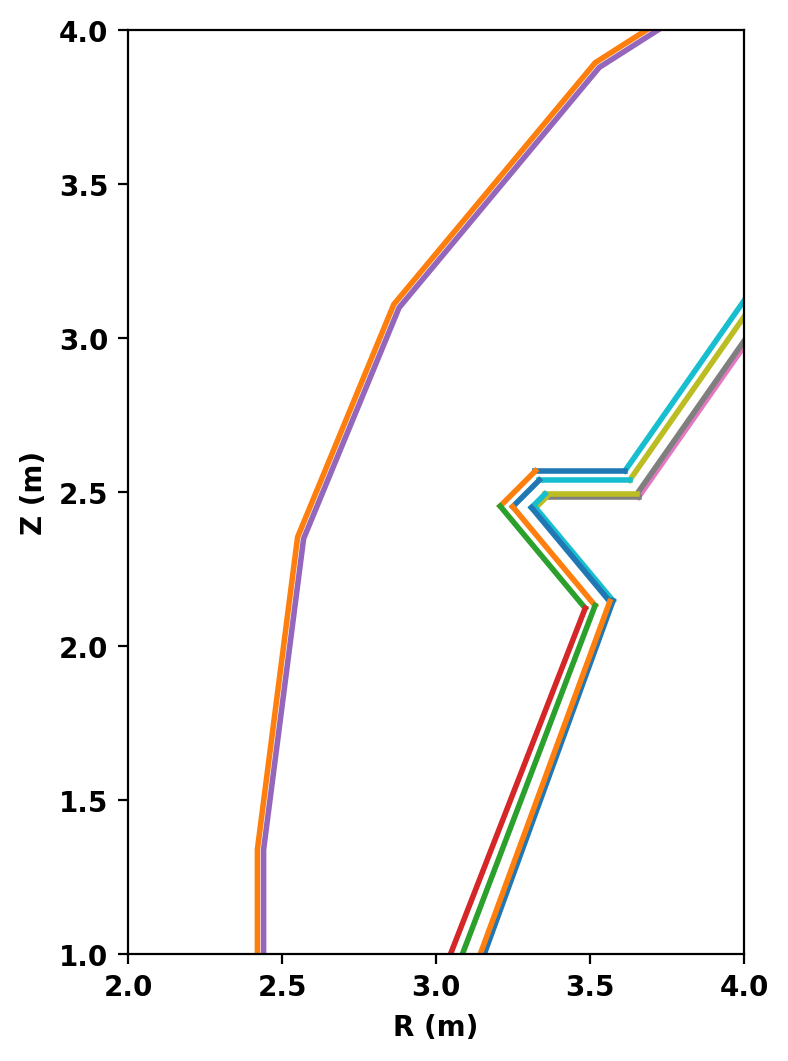

In [113]:
fig, ax = plt.subplots(1,1)
gs_mesh.plot_topology(fig,ax)
ax.set_xlim([2,4])
ax.set_ylim(1,4)

## Create mesh

Now we generate the actual mesh using the `build_mesh` method. Additionally, since coil and conductor regions are defined, the `get_coils` and `get_conductors` methods should also be called to get descriptive dictionaries for later use in TokaMaker. This step may take a few moments as triangle generates the mesh.

In [ ]:
mesh_pts, mesh_lc, mesh_reg = gs_mesh.build_mesh()
coil_dict = gs_mesh.get_coils()
cond_dict = gs_mesh.get_conductors()

Assembling regions:
  # of unique points    = 2283
  # of unique segments  = 178
Generating mesh:
  # of points  = 13223
  # of cells   = 26304
  # of regions = 23


## Plot resulting regions and grid

We now plot the mesh by region to inspect proper generation.

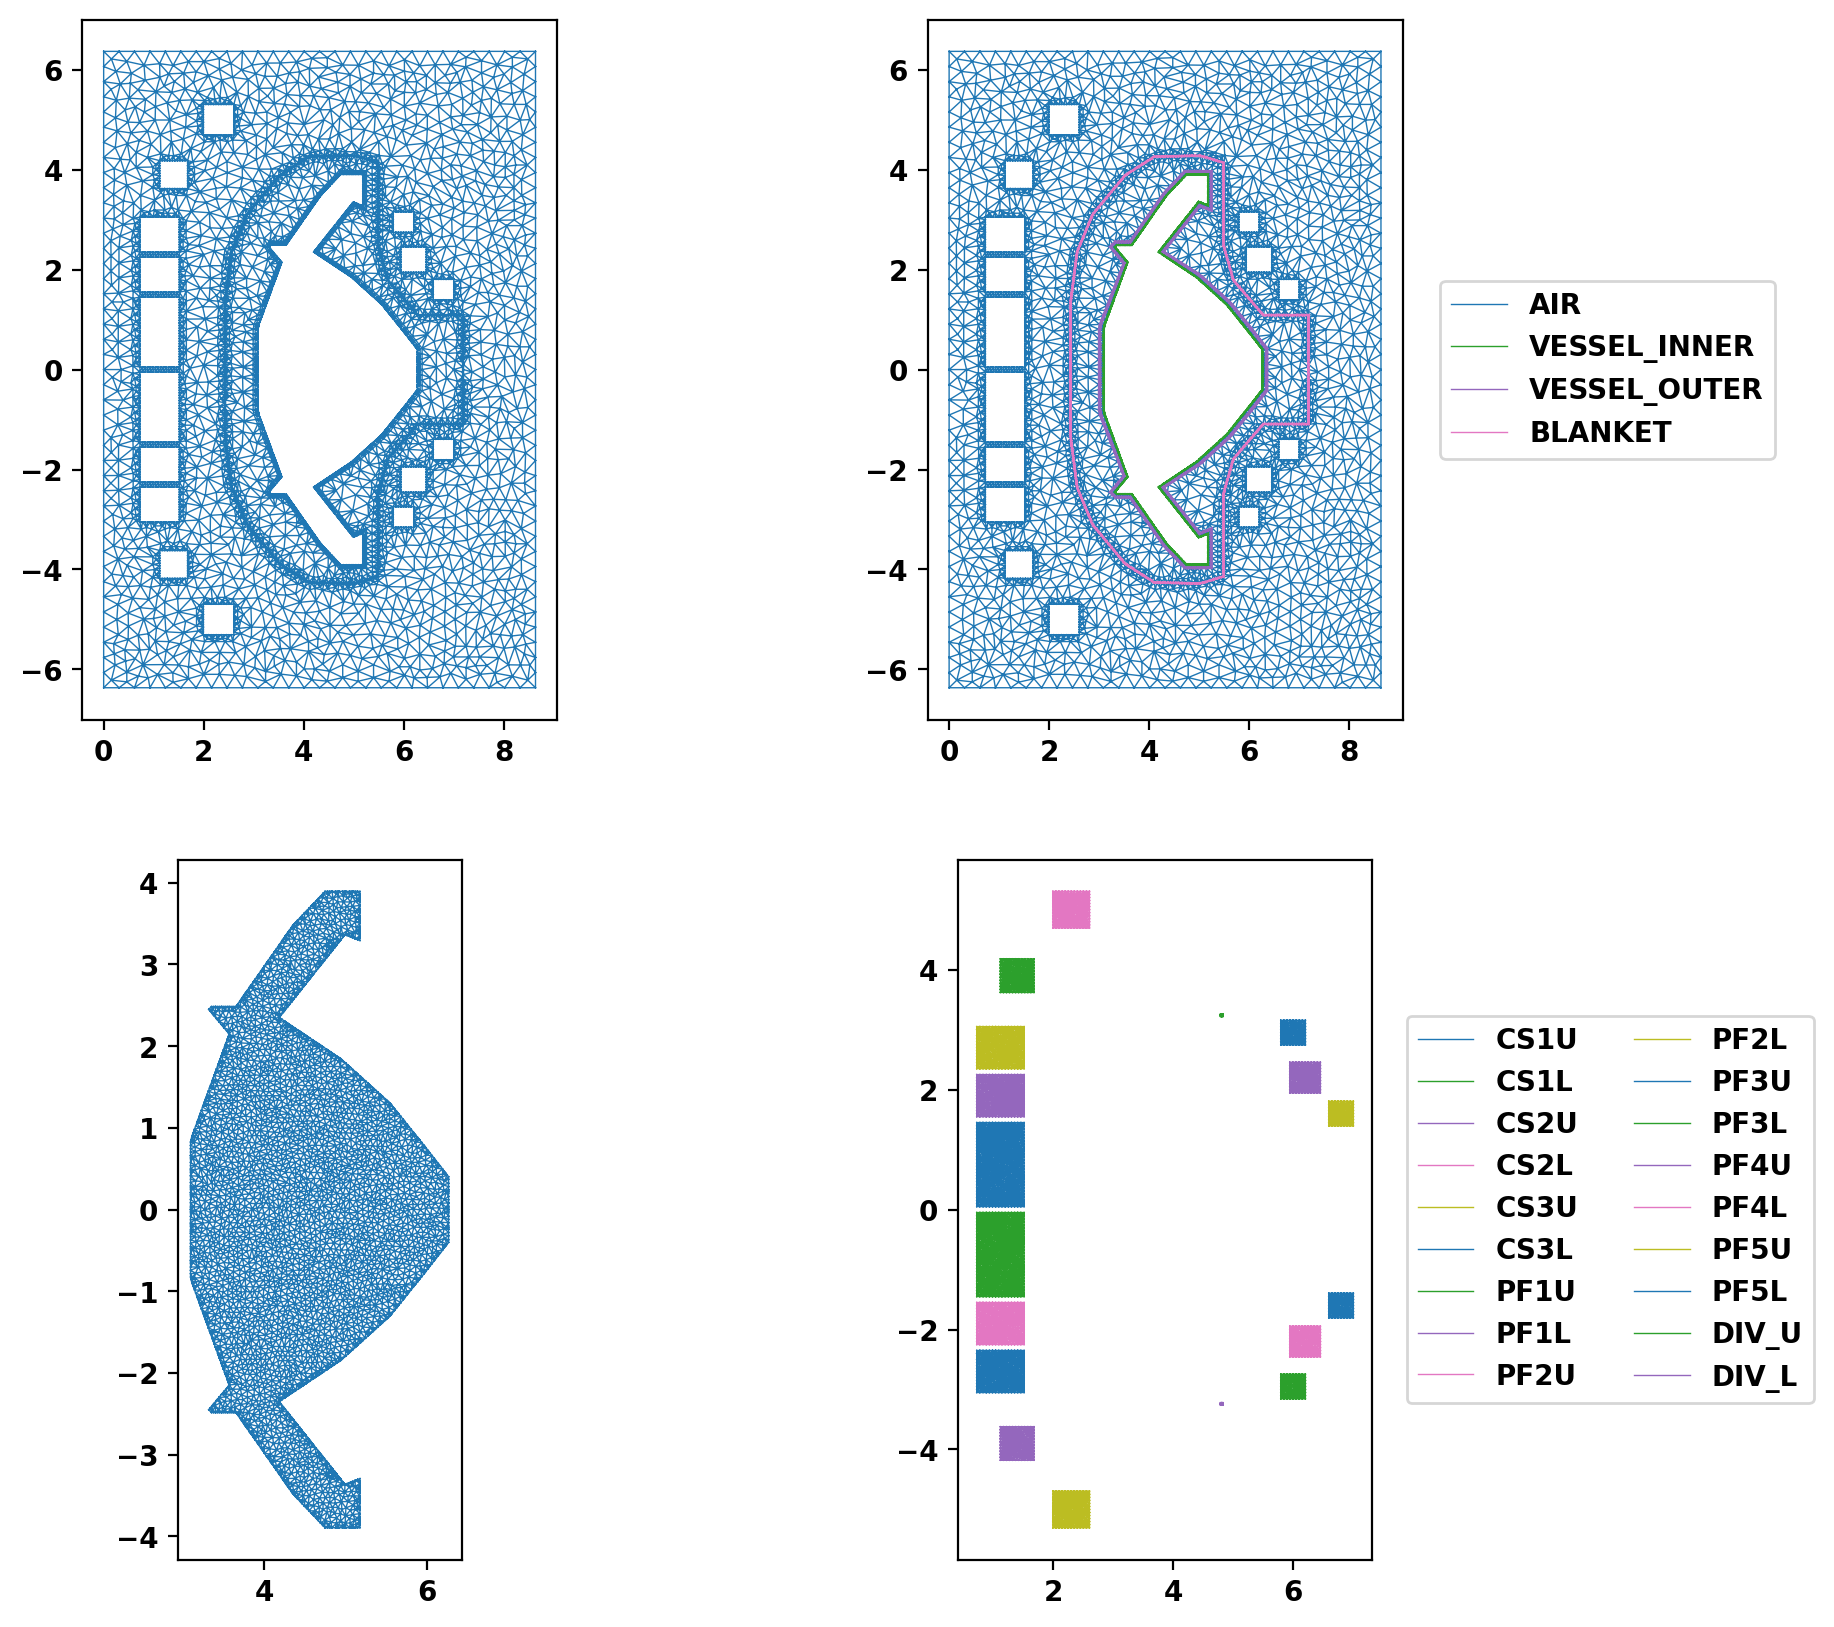

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
ax[0,0].triplot(mesh_pts[:,0],mesh_pts[:,1],mesh_lc[mesh_reg==2,:],lw=0.5)
ax[1,0].triplot(mesh_pts[:,0],mesh_pts[:,1],mesh_lc[mesh_reg==1,:],lw=0.5)
for key, cond in cond_dict.items():
    ax[0,1].triplot(mesh_pts[:,0],mesh_pts[:,1],mesh_lc[mesh_reg==cond['reg_id'],:],lw=0.5,label=key)
for key, coil in coil_dict.items():
    ax[1,1].triplot(mesh_pts[:,0],mesh_pts[:,1],mesh_lc[mesh_reg==coil['reg_id'],:],lw=0.5,label=key)
for ax_tmp in ax.flatten():
    ax_tmp.set_aspect('equal','box')
ax[0,1].legend(bbox_to_anchor=(1.05,0.5), loc='center left')
_ = ax[1,1].legend(bbox_to_anchor=(1.05,0.5), ncol=2, loc='center left')

plt.show()

AIR
VESSEL_INNER
VESSEL_OUTER
BLANKET


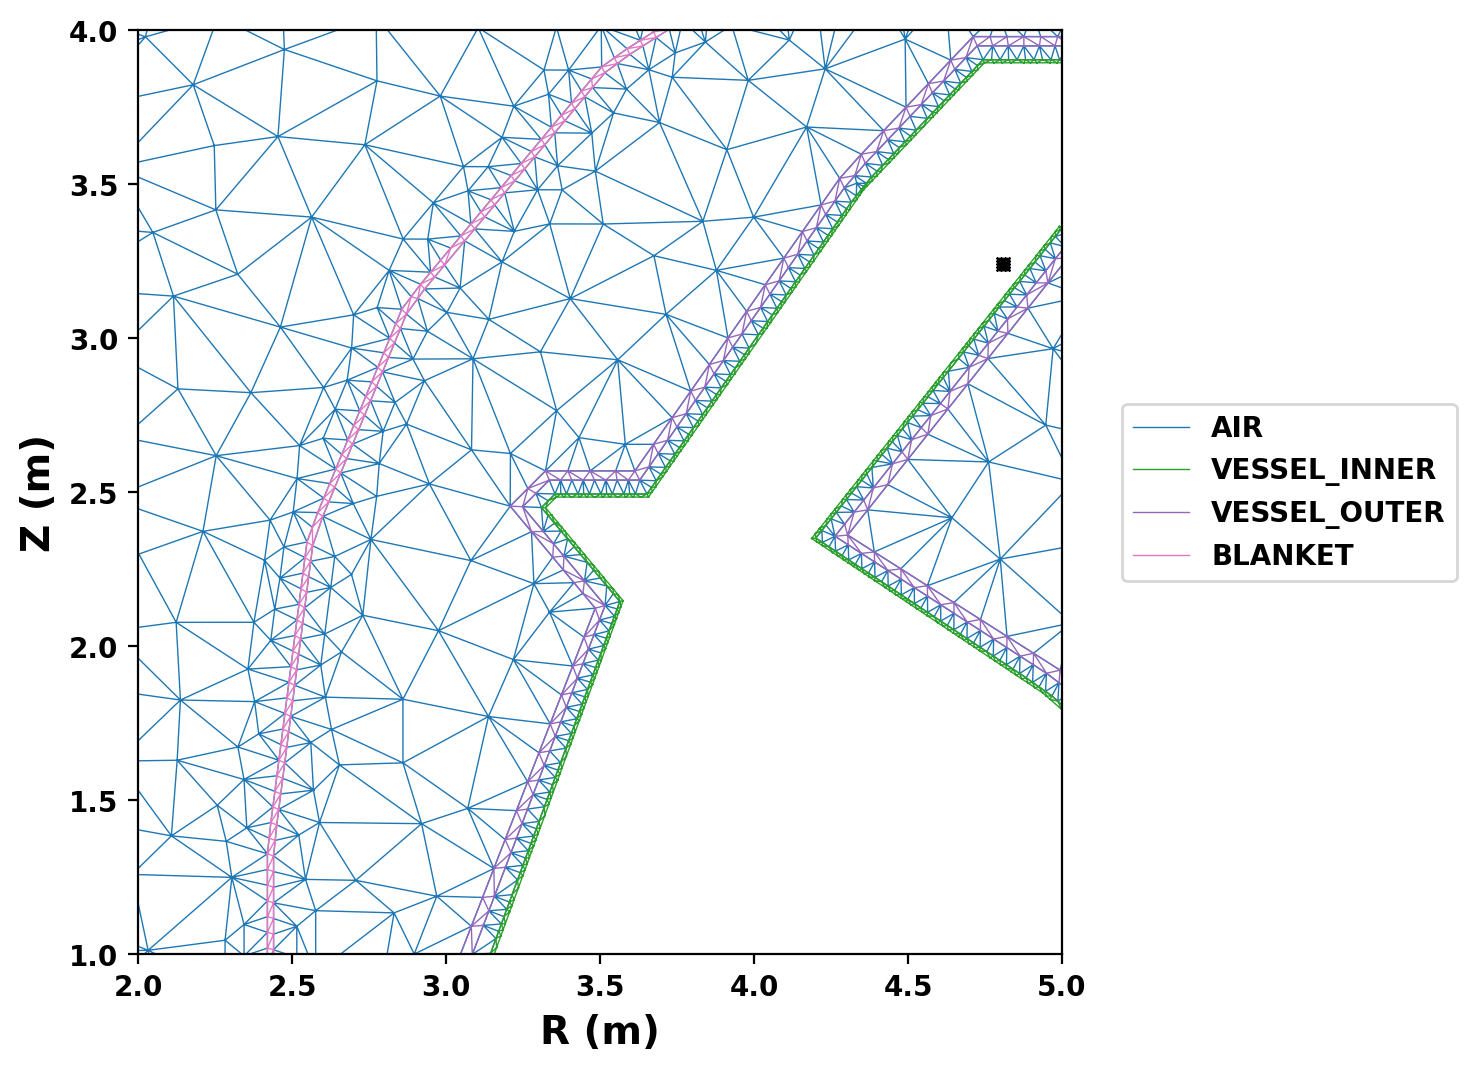

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,6))

for key, cond in cond_dict.items():
    print(key)
    ax.triplot(mesh_pts[:,0],mesh_pts[:,1],mesh_lc[mesh_reg==cond['reg_id'],:],lw=0.5,label=key)
for key, coil in coil_dict.items():
    ax.triplot(mesh_pts[:,0],mesh_pts[:,1],mesh_lc[mesh_reg==coil['reg_id'],:],lw=0.5,color='k')
    
ax.set_aspect('equal','box')
ax.set_xlim(2,5)
ax.set_ylim(1,4)
ax.legend(bbox_to_anchor=(1.05,0.5), loc='center left')
ax.set_xlabel('R (m)', fontsize=14)
ax.set_ylabel('Z (m)', fontsize=14)

plt.show()

## Save mesh for later use

As generation of the mesh often takes comparable, or longer, time compare to runs in TokaMaker it is useful to separate generation of the mesh into a different script as demonstrated here. The method `save_gs_mesh` can be used to save the resulting information for later use. This is done using and an HDF5 file through the h5py library.

In [117]:
fname = jsonname 

if include_FLIBE:
    fname += f'withFLIBE'

save_gs_mesh(mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict,"meshes/arc_mesh_divcoil_" + str(ind))